## Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

## Set seed

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
set_seed(42)

## Load data

In [ ]:
df = pd.read_csv('./data/raw_data/bank_marketing_dataset.csv')

print(df.head())
print(df.describe())
print(df.dtypes)

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

## Pre-process data

#### Change to categorical variables to binary/ordinal values

In [10]:
## Convert binary categorical variables to numeric
binary_features = ['housing', 'loan', 'subscribed']
for col in binary_features:
    df[col] = df[col].map({'no': 0, 'yes': 1})

## Convert contact type to binary
df['contact'] = df['contact'].map({'telephone': 0, 'cellular': 1})

## Convert to ordinal values
poutcome_mapping = {'failure': 0, 'nonexistent': 1, 'success': 2}
df['poutcome'] = df['poutcome'].map(poutcome_mapping)

default_mapping = {'no': 0, 'unknown': 1, 'yes': 2}
df['default'] = df['default'].map(default_mapping)

## Bin pdays and previous
df['pdays_bins'] = df['pdays'].apply(lambda x: 'Never Contacted' if x == 999 else ('1-5' if x <= 5 else '6+'))
df['previous_bins'] = pd.cut(df['previous'], bins=[-1, 0, 1, float('inf')], labels=['Never', '1', '2+'])

## Drop unnecessary columns
df = df.drop(columns=['pdays', 'previous', 'emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'])

## Calculate ROI for each customer

#### Steps to calculating ROI
- Calculate conversion rate and previous campaign success rate
- Calculate CLV
    - Initialize base CLV
    - Consider previous campaign outcome
        - Factor in probability of conversion and adjust CLV accordingly
    - Increase CLV based on customer demographic (e.g. highly educated, well-paying job, marital status etc)
    - Decrease CLV is customer has defaulted
- Calculate Cost
    - Initialize cost depending on whether customer is contacted through cellular or telephone line
        - Cellular costs more, telephone is slightly cheaper
- ROI = (Total CLV - Total cost) / Total cost * 100

In [11]:
## (Take conversion rate/previous campaign success rate into account)
## Calculate conversion rate among those who did not subscribe in previous campaign
success_df = df[df['poutcome'] != 2]
conversion_rate = sum(success_df['subscribed'] == 1) / success_df.shape[0]

## Calculate previous campaign success rate
prev_campaign = df['poutcome'].value_counts()
prev_success = prev_campaign[2] / (prev_campaign[0] + prev_campaign[2])

## Function to calculate CLV
def calculate_clv(row):
    clv = 100  # base CLV
    # Factor in previous campaign outcome
    if row['poutcome'] == 2:
        prob_conversion = 1 + prev_success
    elif row['poutcome'] == 0:
        prob_conversion = conversion_rate
    else:
        prob_conversion = 1
    clv *= prob_conversion # Adjust CLV based on conversion probability
    # Factor in other customer attributes
    if row['subscribed'] == 1:
        clv += 200
    if row['housing'] == 1:
        clv += 100  # Housing loan customers indicate a long-term banking relationship
    if row['loan'] == 1:
        clv += 100  # Personal loan customers may need more banking products
    if row['marital'] == 'single':
        clv += 50 # More financial independence
    if row['education'] in ['university.degree', 'professional.course']:
        clv += 50  # More financially aware customers may invest more
    if row['job'] in ['management', 'entrepreneur', 'self-employed']:
        clv += 50  # Higher earning potential, more banking needs
    if row['default'] == 2:
        clv -= 200 # Penalty for defaulting customers
    return max(clv, 0)  # CLV should be non-negative

df['clv'] = df.apply(calculate_clv, axis=1)

## Function to calculate customer acquisition cost
def calculate_acquisition_cost(row):
    if row['campaign'] == 0 or row['duration'] == 0:
        return 0.01  # minimum acquisition cost to avoid division by 0
    cps = 0.05 if row['contact'] == 1 else 0.03 # cost per second
    return row['campaign'] * row['duration'] * cps

df['acquisition_cost'] = df.apply(calculate_acquisition_cost, axis=1)

# Calculate ROI
df['roi'] = ((df['clv'] - df['acquisition_cost']) / df['acquisition_cost']) * 100

## Visualizations of ROI

#### Plot of ROI against education level
- Customers with university degrees generally have greater ROI

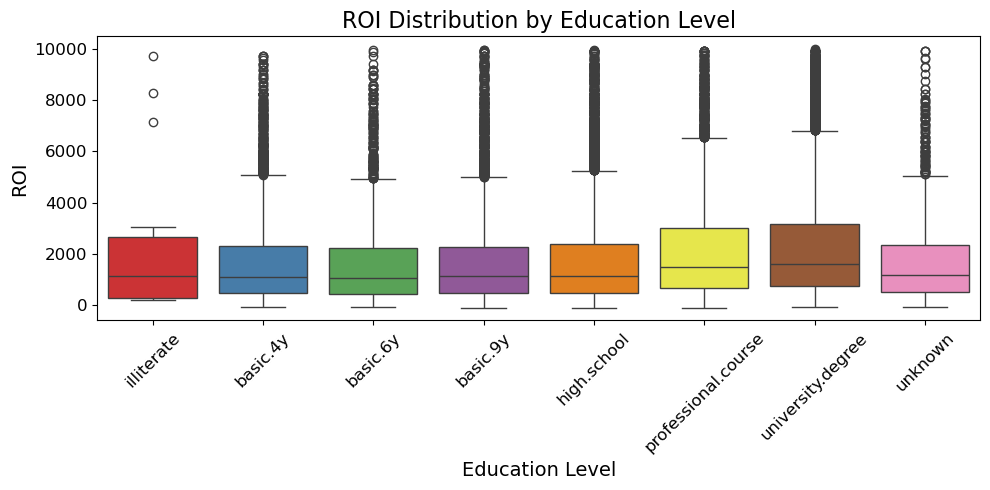

In [ ]:
# Order by education level
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']
df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)

# ROI against Education
plot_df = df[df['roi'] < 10000] # Exclude outliers

plt.figure(figsize=(10, 5))
sns.boxplot(x='education', y='roi', data=plot_df, hue='education', palette='Set1', legend=False)
plt.title('ROI Distribution by Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('ROI', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### Plot of ROI against marital status
- Customers that are married tend to have greater ROI

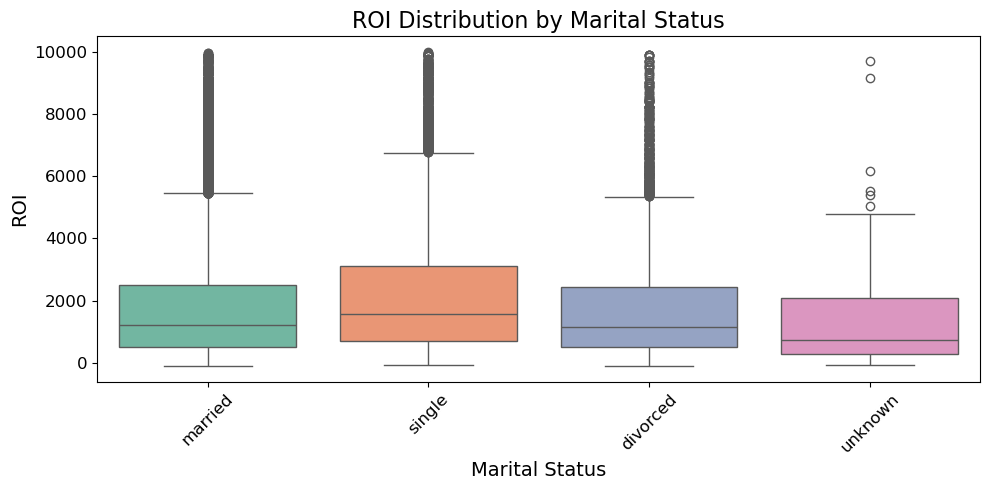

In [ ]:
# ROI against Marital Status
plot_df = df[df['roi'] < 10000] # Exclude outliers

plt.figure(figsize=(10, 5))
sns.boxplot(x='marital', y='roi', data=plot_df, hue='marital', palette='Set2', legend=False)
plt.title('ROI Distribution by Marital Status', fontsize=16)
plt.xlabel('Marital Status', fontsize=14)
plt.ylabel('ROI', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### Plot of Cost against Revenue

Turning point (Cost vs ROI): Acquisition cost = 2.13


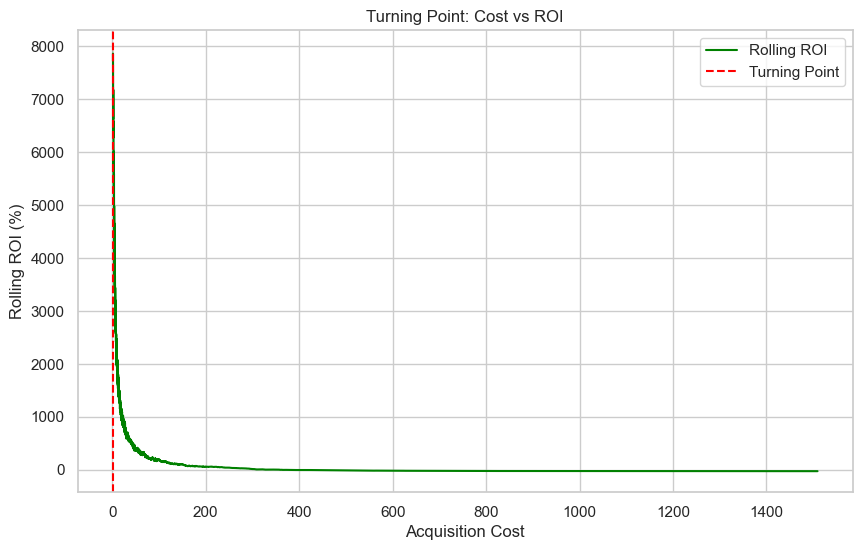

In [19]:
# Set style
sns.set_theme(style="whitegrid")

# Cost vs ROI Plot
plot_df = df[df['roi'] < 10000]

## Find turning point for ROI
roi_smoothed = plot_df[['acquisition_cost', 'roi']].sort_values(by='acquisition_cost')
rolling_roi = roi_smoothed['roi'].rolling(100).mean()
turning_point_roi_idx = rolling_roi.diff().idxmax()  # max increase in ROI
turning_point_roi_cost = plot_df.loc[turning_point_roi_idx, 'acquisition_cost']
print(f"Turning point (Cost vs ROI): Acquisition cost = {turning_point_roi_cost:.2f}")

## Plot Cost vs ROI with turning point
plt.figure(figsize=(10,6))
sns.lineplot(x=roi_smoothed['acquisition_cost'], y=rolling_roi, color='green', label='Rolling ROI')
plt.axvline(x=turning_point_roi_cost, color='red', linestyle='--', label='Turning Point')
plt.xlabel("Acquisition Cost")
plt.ylabel("Rolling ROI (%)")
plt.title("Turning Point: Cost vs ROI")
plt.legend()
plt.show()

#### Plot of Cost against ROI

Turning point (Cost vs Revenue): Acquisition cost = 32.70


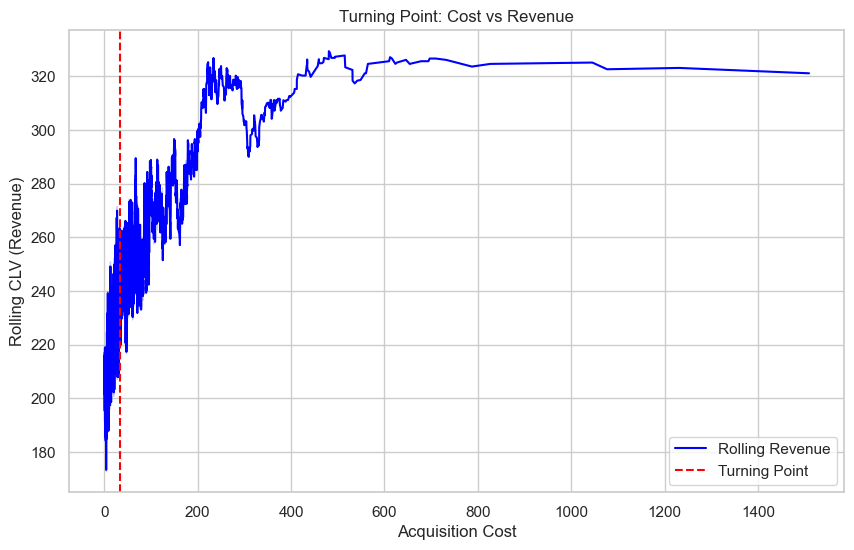

In [20]:
# Cost vs Revenue (CLV) Plot
## Find turning point for Revenue
rev_smoothed = df[['acquisition_cost', 'clv']].sort_values(by='acquisition_cost')
rolling_rev = rev_smoothed['clv'].rolling(100).mean()
turning_point_rev_idx = rolling_rev.diff().idxmax()  # max increase in revenue
turning_point_rev_cost = df.loc[turning_point_rev_idx, 'acquisition_cost']
print(f"Turning point (Cost vs Revenue): Acquisition cost = {turning_point_rev_cost:.2f}")

## Plot Cost vs Revenue with turning point
plt.figure(figsize=(10,6))
sns.lineplot(x=rev_smoothed['acquisition_cost'], y=rolling_rev, color='blue', label='Rolling Revenue')
plt.axvline(x=turning_point_rev_cost, color='red', linestyle='--', label='Turning Point')
plt.xlabel("Acquisition Cost")
plt.ylabel("Rolling CLV (Revenue)")
plt.title("Turning Point: Cost vs Revenue")
plt.legend()
plt.show()

## Use OneHotEncoder to handle categorical variables

In [21]:
# Encode categorical variables
categorical_features = ['job', 'marital', 'education', 'month', 'day_of_week', 'pdays_bins', 'previous_bins']
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_encoded = encoder.fit_transform(df[categorical_features])
categorical_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())

## Drop original columns and merge encoded ones
df = df.drop(columns=categorical_features)
df = pd.concat([df, categorical_df], axis=1)

## Fill missing values
imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Display the dataframe
print(df[['age', 'campaign', 'duration', 'contact', 'subscribed', 'roi']])

        age  campaign  duration  contact  subscribed          roi
0      56.0       1.0     261.0      0.0         0.0  1177.139208
1      57.0       1.0     149.0      0.0         0.0  2137.136465
2      37.0       1.0     226.0      0.0         0.0  2849.852507
3      40.0       1.0     151.0      0.0         0.0  2107.505519
4      56.0       1.0     307.0      0.0         0.0  2071.552660
...     ...       ...       ...      ...         ...          ...
41183  73.0       1.0     334.0      1.0         1.0  2594.610778
41184  46.0       1.0     383.0      1.0         0.0   683.289817
41185  56.0       2.0     189.0      1.0         0.0  1222.751323
41186  44.0       1.0     442.0      1.0         1.0  1483.710407
41187  74.0       3.0     239.0      1.0         0.0   344.654154

[41188 rows x 6 columns]


## Split and scale data

In [22]:
# Define features and target
X = df.drop(columns=['roi'])
y = df['roi']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Train model using Random Forest

##### MAE: 109.220
##### MRSE: 3569.297
##### R2 Score: 0.909

##### Most important features in the training set are "acquisition_cost", "duration" and "clv".

In [23]:
# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=df.drop(columns=['roi']).columns)
print("Feature Importances:")
print(feature_importances.sort_values(ascending=False))

MAE: 109.22011354690929
RMSE: 3569.2974607087754
R2 Score: 0.9091398346500229
Feature Importances:
acquisition_cost                 5.485078e-01
duration                         3.672360e-01
clv                              2.294062e-02
month_aug                        7.729743e-03
campaign                         7.674476e-03
day_of_week_mon                  6.694234e-03
education_university.degree      6.381767e-03
housing                          5.528746e-03
day_of_week_tue                  5.239839e-03
month_may                        3.499708e-03
education_basic.9y               3.416825e-03
age                              3.233548e-03
education_high.school            3.079589e-03
contact                          2.780046e-03
job_management                   2.473101e-03
job_blue-collar                  2.091393e-03
poutcome                         4.156101e-04
job_student                      2.018202e-04
loan                             1.951867e-04
day_of_week_wed            

## Plot predicted v.s. actual values

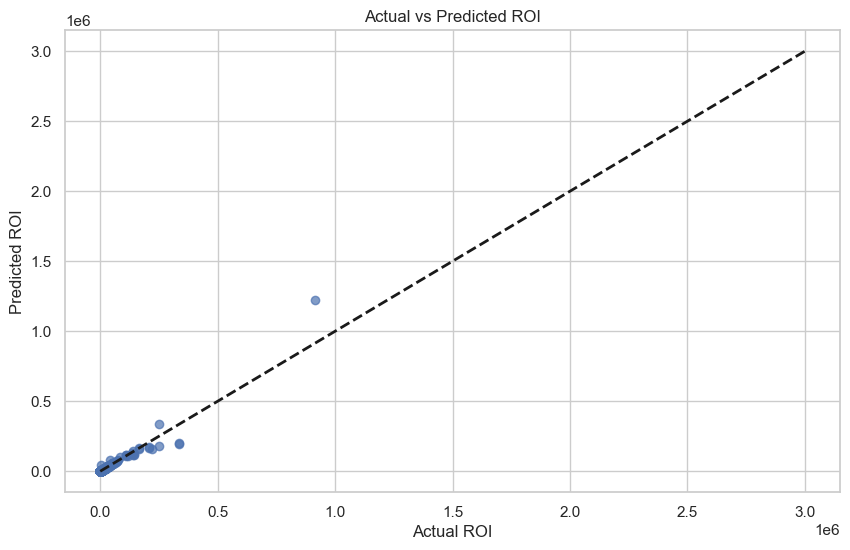

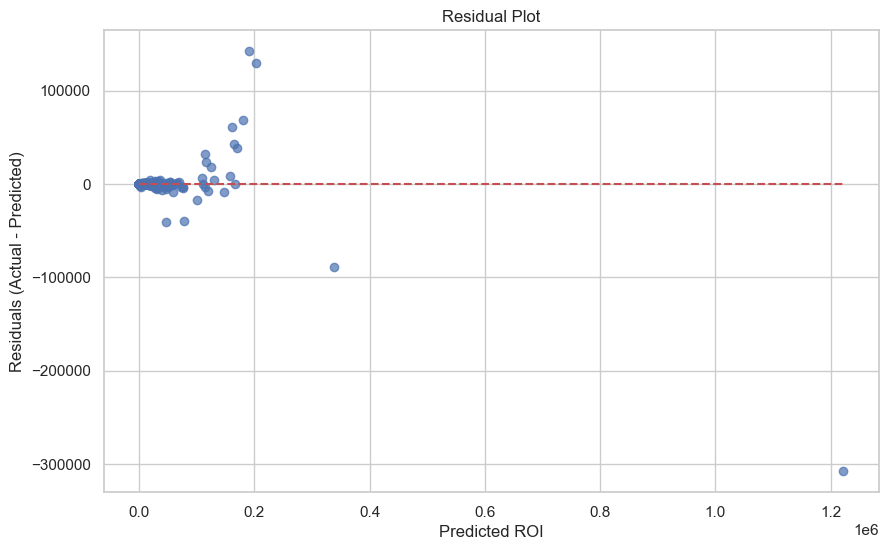

In [24]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ideal line
plt.xlabel('Actual ROI')
plt.ylabel('Predicted ROI')
plt.title('Actual vs Predicted ROI')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted ROI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()